# Gathering and Processing the Images

**Goals:** Download images, remove duplicate images, prepare training, 
validation, and test datasets.

In [1]:
# Load required packages and modules.import pathlib
import pathlib
import os
import hashlib
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import splitfolders
import pandas as pd
from PIL import Image

# Set the backend of matplotlib to 'inline'.
%matplotlib inline

# Create plots using seaborn's default aesthetic arguments. 
sns.set()

# Make this notebook's output identical across runs.
random.seed(1)
np.random.seed(1)

## 1. Download Images

We downloaded about 6,000 total images of eight types of houses using 
Google search and the Chrome extension `Download All Images.` After manually 
inspecting each image, we deleted mislabeled and fake images, leaving about 
1,200 images. We focused on only six classes, with 950 total images. We 
downloaded additional images from zillow.com, bringing the total number of 
images to 2,100, with each of the six classes containing 350 images.

In [2]:
# Path to the images.
DATA_DIR_PATH = pathlib.Path('/home/dn/notebooks/house_classifier/data')
IMAGES_DIR_PATH = DATA_DIR_PATH.joinpath('images')

How many images are there?

In [3]:
print('Total number of images:', len(list(IMAGES_DIR_PATH.glob('*/*.jpeg'))))

Total number of images: 2100


In [4]:
# Print directory names.
dirs = sorted(os.listdir(IMAGES_DIR_PATH))
print(dirs)

['cape_cod', 'colonial', 'craftsman', 'mediterranean', 'ranch', 'tudor']


Each directory contains images of that style of house. Here are some
'Cape Cod' style houses:

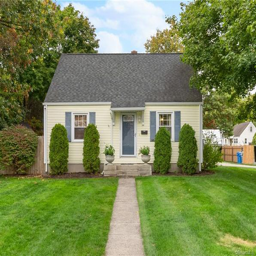

In [5]:
cape_cod = list(IMAGES_DIR_PATH.glob('cape_cod/*.jpeg'))
image = Image.open(str(cape_cod[8]))
image = image.resize((256, 256))
image

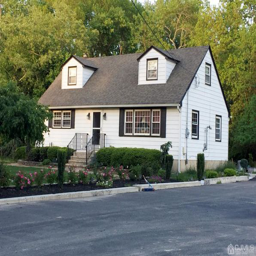

In [6]:
image = Image.open(str(cape_cod[15]))
image = image.resize((256, 256))
image

How many images are there of each type?

In [7]:
print('Number of Images')
print('----------------')
for dir in dirs:
    print(f'{dir}:', len(list(IMAGES_DIR_PATH.glob(f'{dir}/*.jpeg'))))

Number of Images
----------------
cape_cod: 350
colonial: 350
craftsman: 350
mediterranean: 350
ranch: 350
tudor: 350


## 2. Remove Duplicate Images

We will remove duplicate images, if any. If we leave these in during 
training, then our model may form a bias towards a particular image it 
sees multiple times in each epoch. First, let's define a function that 
computes the hash value of a given image:

In [8]:
def hash_value(file_path):
    with open(file_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

Let's identify the duplicate images:

In [9]:
hash_keys = dict()
duplicates = dict()
for dir in dirs:
    dir_path = IMAGES_DIR_PATH.joinpath(dir)
    files = os.listdir(dir_path)    
    for file in files:
        file_path = dir_path.joinpath(file)
        hash_key = hash_value(file_path)
        if hash_key not in hash_keys:
            hash_keys[hash_key] = file_path
        else:
            duplicates[file_path] = hash_keys[hash_key] 

How many duplicate images are there?

In [10]:
print('Number of duplicate images:', len(duplicates))

Number of duplicate images: 4


Let's visualize the duplicate images:

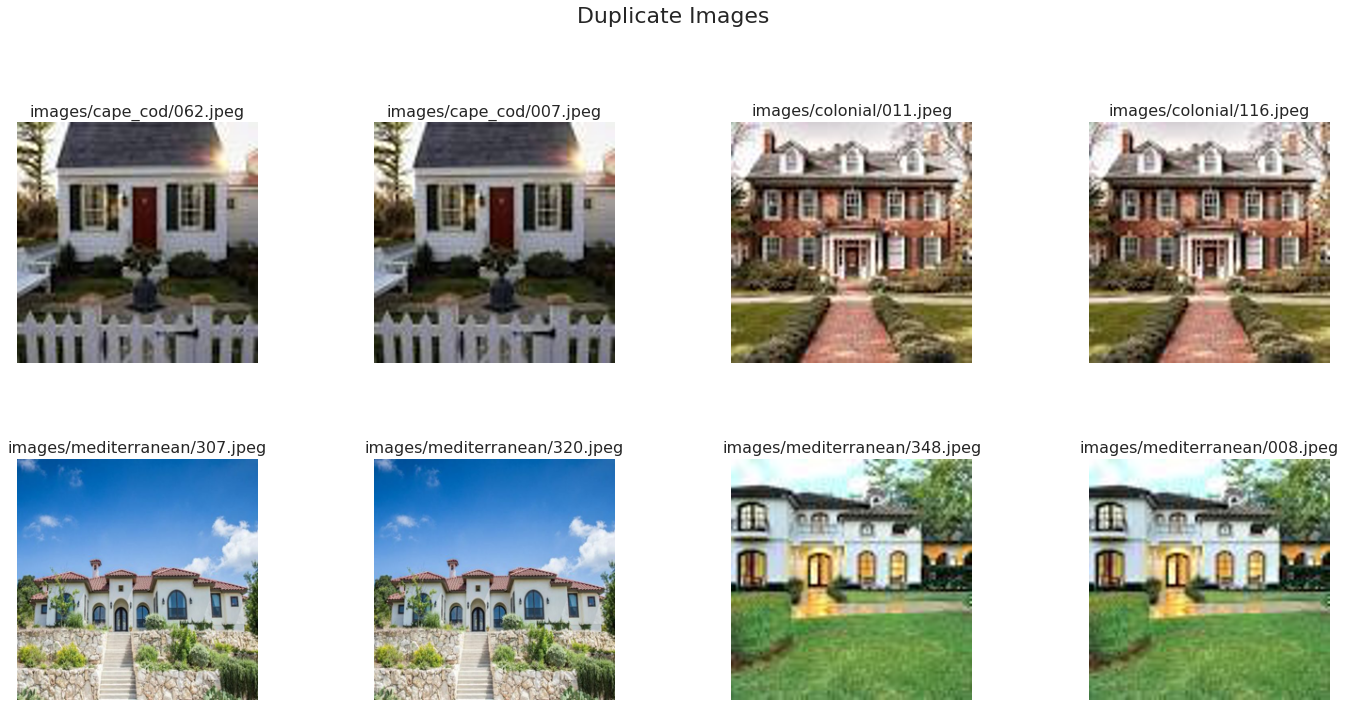

In [11]:
n_cols = 4
n_rows = 2
aspect = 1
fig = plt.figure(figsize=(20, (n_rows/n_cols)*(20/aspect)))
fig.suptitle('Duplicate Images', fontsize=22)
i = 1
for org, dup in duplicates.items():    
    ax = fig.add_subplot(n_rows, n_cols, i)
    ax.imshow(np.array(Image.open(org).resize((256, 256))))
    ax.set_title(str(org).split('data/', 1)[1], fontsize=16)
    ax.axis('off')
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    ax.imshow(np.array(Image.open(dup).resize((256, 256))))
    ax.set_title(str(dup).split('data/', 1)[1], fontsize=16)
    ax.axis('off')
    i += 2
fig.tight_layout()
fig.subplots_adjust(top=0.82, wspace=0.1, hspace=0.4)  

Let's remove duplicate images:

In [12]:
for file_path in duplicates:
    os.remove(file_path)

How many images of each type are left?

In [13]:
# Print number of images of each type.
print('Number of Images')
print('----------------')
for dir in dirs:
    print(f'{dir}:', len(list(IMAGES_DIR_PATH.glob(f'{dir}/*.jpeg'))))

Number of Images
----------------
cape_cod: 349
colonial: 349
craftsman: 350
mediterranean: 348
ranch: 350
tudor: 350


## 3. Prepare Training, Validation, and Test Datasets

Let's split the image collection into training (75%), validation (15%), and
test (10%) datasets:

In [14]:
SPLITS_DIR_PATH = DATA_DIR_PATH.joinpath('splits')
splitfolders.ratio(IMAGES_DIR_PATH,
                   output=SPLITS_DIR_PATH,
                   seed=1,
                   ratio=(0.75, 0.15, 0.1))

Copying files: 2096 files [00:00, 5782.64 files/s]


Let's take a look at the number of images of each class in each of the 
datasets:

In [15]:
datasets = {'Training Set': SPLITS_DIR_PATH.joinpath('train'), 
            'Validation Set': SPLITS_DIR_PATH.joinpath('val'), 
            'Test Set': SPLITS_DIR_PATH.joinpath('test')}

counts = {key: {} for key in datasets}

for key in datasets:  
    for dir in dirs:        
        counts[key][dir] = len(list(datasets[key].glob(f'{dir}/*.jpeg')))
df = pd.DataFrame(counts).sort_index(axis='index')
print(df)

               Training Set  Validation Set  Test Set
cape_cod                261              52        36
colonial                261              52        36
craftsman               262              52        36
mediterranean           261              52        35
ranch                   262              52        36
tudor                   262              52        36
